In [25]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from joblib import parallel_backend

galaxy_data = pd.read_csv("clean_data.csv")
all_inputs = galaxy_data.drop(columns=["subclass"]).values
all_labels = galaxy_data["subclass"].values
nr_features = all_inputs.shape[1]

In [26]:

#decision_tree_classifier = DecisionTreeClassifier()
#cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=StratifiedKFold(n_splits=10))

#print(cv_scores)
#plt.hist(cv_scores)
#plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [27]:
all_inputs = galaxy_data.drop(columns=["subclass"]).values
all_labels = galaxy_data["subclass"].values

(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(
    all_inputs, all_labels, test_size=0.25
)

In [42]:
def test_classifier(clf, data, labels, parameter_grid, cv=StratifiedKFold(n_splits=2)):
    grid_search = GridSearchCV(clf, parameter_grid, cv=cv, n_jobs=-1)
    with parallel_backend('loky'):
        grid_search.fit(data, labels)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

    return grid_search

In [61]:
def plot_grid_search(grid_search, labels, shape):
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

    grid_visualization = grid_search.cv_results_['mean_test_score']
    grid_visualization.shape = shape
    #grid_visualization = grid_visualization.reshape(-1, s1, s2, s3, s4)
    print(grid_visualization.shape)

    #plot_grid = sb.PairGrid(grid_visualization)
    #plot_grid.map_diag(plt.hist)
    #def pairgrid_heatmap(grid_visualization):
    #    sb.heatmap(grid_visualization, cmap='Blues', annot=True)

    # TODO: plot pair grid heatmap
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            #plt.plot(x=labels[i], y=labels[j], kind='scatter', color='blue', alpha=0.5)
            print(labels[i], labels[j])
            #sb.heatmap(..., cmap='Blues', annot=True)
    # 15 * 4 * 3 * 2
    # depth, features
    # 1, 2, 3, 4, 5, ..., 14, 15


    #plot_grid.map_offdiag(pairgrid_heatmap)
    #for i in range(len(labels)):
    #    for j in range(i + 1, len(labels)):
    #        pass
    
    #print(grid_search.cv_results_['mean_test_score'])
    # grid_visualization.shape = shape
    #sb.heatmap(grid_visualization, cmap='Blues', annot=True)
    #plt.yticks(np.arange(shape[0]) + 0.5, grid_search.param_grid[labels[0]])
    #plt.xticks(np.arange(shape[1]) + 0.5, grid_search.param_grid[labels[1]])
    #plt.xlabel(labels[0])
    #plt.ylabel(labels[1])

In [30]:
decision_tree_classifier = DecisionTreeClassifier()

max_depth = 15
max_features = nr_features
features_step = 8
nr_tested_features = max_features // features_step + 1
nr_criterion = 3
nr_splitter = 2

parameter_grid = {
    "max_depth": list(range(1, max_depth + 1)),
    "max_features": list(range(1, max_features + features_step, features_step)),
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
}
print(parameter_grid)

grid_search = test_classifier(
    decision_tree_classifier, all_inputs, all_labels, parameter_grid
)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'max_features': [1, 9, 17, 25], 'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random']}
Best score: 0.8719390068704292
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 25, 'splitter': 'best'}


In [62]:
plot_grid_search(
    grid_search,
    ["max_depth", "max_features", "criterion", "splitter"],
    (max_depth, nr_tested_features, nr_criterion, nr_splitter),
)

Best score: 0.8719390068704292
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 25, 'splitter': 'best'}
(15, 4, 3, 2)
max_depth max_features
max_depth criterion
max_depth splitter
max_features criterion
max_features splitter
criterion splitter
[[[[0.75543976 0.75419843]
   [0.80441545 0.75419843]
   [0.80887799 0.77079706]]

  [[0.80887799 0.78013281]
   [0.78338501 0.75420869]
   [0.80908317 0.76978147]]

  [[0.8095448  0.77366963]
   [0.8177006  0.79683403]
   [0.80526685 0.75592193]]

  [[0.82957007 0.77874772]
   [0.82801073 0.78027634]
   [0.82857497 0.79482325]]]


 [[[0.80475387 0.75976903]
   [0.83093449 0.78773456]
   [0.83537658 0.79427969]]

  [[0.83560228 0.81115555]
   [0.81805974 0.75515251]
   [0.84627147 0.79353054]]

  [[0.85175995 0.81188383]
   [0.85444773 0.82232727]
   [0.81433562 0.7692688 ]]

  [[0.85083664 0.82277881]
   [0.85426308 0.81673628]
   [0.85905394 0.82117836]]]


 [[[0.82906738 0.7553987 ]
   [0.86074666 0.80628229]
   [0.860202

In [ ]:
def print_classification_report(model, testing_inputs, testing_classes):
    # plot histogarm with feature importance
    plt.bar(galaxy_data.drop(columns=["subclass"]).columns, model.feature_importances_)
    plt.xticks(rotation=90)

    # print(galaxy_data.drop(columns=["subclass"]).columns)
    # print(model.feature_importances_)
    # print()
    
    print(classification_report(testing_classes, model.predict(testing_inputs)))

    cf_matrix = confusion_matrix(testing_classes, model.predict(testing_inputs))
    cm = ConfusionMatrixDisplay(cf_matrix, display_labels=model.classes_)
    cm.plot()
    plt.show()

              precision    recall  f1-score   support

   STARBURST       0.79      0.75      0.77      6085
 STARFORMING       0.92      0.93      0.93     18285

    accuracy                           0.89     24370
   macro avg       0.85      0.84      0.85     24370
weighted avg       0.89      0.89      0.89     24370



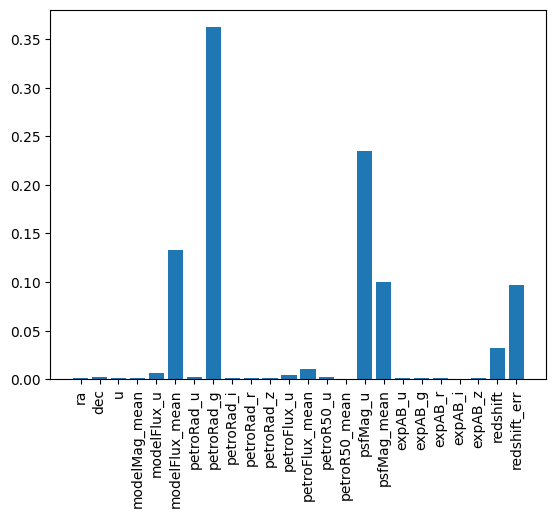

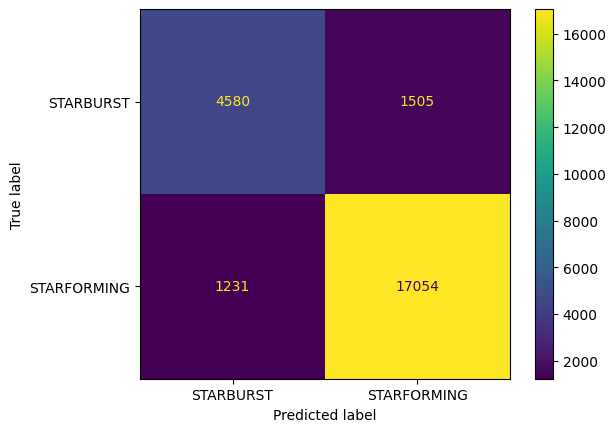

In [ ]:
print_classification_report(grid_search.best_estimator_, testing_inputs, testing_classes)